# VAE sur le jeu de données CelebA - Florian GIURGIU & Pierre BOURGEY

L'objectif de ce projet est d'entrainer un VAE sur le jeu de données [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), disponible sur [torchvision](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CelebA.html) ou un sous ensemble de ce jeu de données.

Trois objectifs, à réaliser séquentiellement:

- Partie 1 : Entrainer le modèle avec flatten puis MLP
- Partie 2 : Utiliser des CNN à la place de MLP (vous pouvez vous inspirer de l'[implementation suivante](https://medium.com/the-generator/a-basic-variational-autoencoder-in-pytorch-trained-on-the-celeba-dataset-f29c75316b26)
- Partie 3 : Trouver un moyen de conditionner le VAE avec les attributs des images (lunette, moustache etc), l'entrainer et générer votre tête avec des lunettes

# Import depuis Google Colab

Dans un premier temps, nous allons réaliser tout les import dont nous aurons besoin.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Compose, Resize, Grayscale

import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
import shutil

import os

import pandas as pd

import time

from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

Puis, nous sélectionnons automatiquement le type de périphérique (GPU ou CPU) disponible pour les calculs PyTorch. Nous affichons le périphérique utilisé, et si c'est un GPU (CUDA), nous affichons également le nom du GPU.

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

if device=="cuda":
  print(torch.cuda.get_device_name(0))

Using cpu device


L'objectif maintenant est d'importer correctement le jeu de données. Pour cela, nous utilisons Kaggle afin d'avoir ceci sur Google Colab (l'exploitation de ce jeu de données en local avec notre matériel demande beaucoup trop de temps, donc il nous faut une solution afin d'utiliser Google Colab).

In [3]:
# Autoriser l'accès à l'API Kaggle
!mkdir -p ~/.kaggle
uploaded = files.upload()

# Déplacer le fichier kaggle.json
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json

# Télécharger le dataset CelebA
!kaggle datasets download -d jessicali9530/celeba-dataset
!mkdir -p data

# Extraire les fichiers
!unzip -q celeba-dataset.zip -d data/celeba

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.32G/1.33G [00:07<00:00, 223MB/s]
100% 1.33G/1.33G [00:07<00:00, 188MB/s]


### Mise en place des caractéristiques
Maintenant que nous avons les images, enregistrons maintenant les caractéristiques des images dans un tableau.

In [34]:
features=np.array(["5_o_Clock_Shadow",
                   "Arched_Eyebrows",
                   "Attractive",
                   "Bags_Under_Eyes",
                   "Bald",
                   "Bangs",
                   "Big_Lips",
                   "Big_Nose",
                   "Black_Hair",
                   "Blond_Hair",
                   "Blurry",
                   "Brown_Hair",
                   "Bushy_Eyebrows",
                   "Chubby",
                   "Double_Chin",
                   "Eyeglasses",
                   "Goatee",
                   "Gray_Hair",
                   "Heavy_Makeup",
                   "High_Cheekbones",
                   "Male",
                   "Mouth_Slightly_Open",
                   "Mustache",
                   "Narrow_Eyes",
                   "No_Beard",
                   "Oval_Face",
                   "Pale_Skin",
                   "Pointy_Nose",
                   "Receding_Hairline",
                   "Rosy_Cheeks",
                   "Sideburns",
                   "Smiling",
                   "Straight_Hair",
                   "Wavy_Hair",
                   "Wearing_Earrings",
                   "Wearing_Hat",
                   "Wearing_Lipstick",
                   "Wearing_Necklace",
                   "Wearing_Necktie",
                   "Young"
                  ])

On prépare les données, on associe les images aux attributs puis on sépare les données de train et de test

In [ ]:
# === 1. Paramètres ===
celeba_root = "/content/data/celeba"
img_dir = os.path.join(celeba_root, "img_align_celeba/img_align_celeba")
attr_path = os.path.join(celeba_root, "list_attr_celeba.csv")
partition_path = os.path.join(celeba_root, "list_eval_partition.csv")

# === 2. Charger les attributs ===
attr_df = pd.read_csv(
    attr_path,
    skiprows=1,
    names=['filename'] + features.tolist(),
    index_col='filename'
)

# === 3. Charger les partitions (0: train, 1: valid, 2: test) ===
partition_df = pd.read_csv(
    partition_path,
    header=None,        # pas d'en-tête
    names=['filename', 'partition'],
    index_col='filename'
)

partition_df.columns = ['partition']

# === 4. Fusionner attributs + partition ===
attr_df['partition'] = partition_df['partition']

# === 5. Définir le dataset personnalisé ===
class CustomCelebADataset(Dataset):
    def __init__(self, img_dir, attr_df, transform=None):
        self.img_dir = img_dir
        self.attr_df = attr_df
        self.transform = transform
        self.image_names = attr_df.index.tolist()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path).float() / 255.0

        label = torch.tensor(self.attr_df.loc[img_name].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

# === 6. Séparer train/test ===
train_df = attr_df[attr_df['partition'] == "0"].drop(columns='partition')
test_df  = attr_df[attr_df['partition'] == "2"].drop(columns='partition')

# === 7. Créer les datasets ===
training_data = CustomCelebADataset(img_dir, train_df)
test_data  = CustomCelebADataset(img_dir, test_df)

In [6]:
print(training_data.__len__())
print(test_data.__len__())

162770
19962


On affiche la 1ère image et ses attributs

['Arched_Eyebrows' 'Attractive' 'Brown_Hair' 'Heavy_Makeup'
 'High_Cheekbones' 'Mouth_Slightly_Open' 'No_Beard' 'Pointy_Nose'
 'Smiling' 'Straight_Hair' 'Wearing_Earrings' 'Wearing_Lipstick' 'Young']


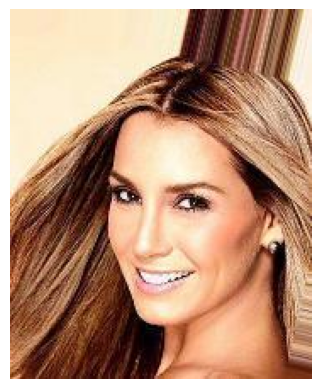

torch.Size([218, 178, 3])


In [7]:
img, attr = training_data[0]
img = img.permute(1, 2, 0)

attr = attr.numpy()

plt.imshow(img)
plt.axis('off')
print(features[attr == 1])
plt.show()
print(img.shape)

On charge les données d'entrainement et de test puis on affiche leur taille

In [8]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 218, 178])
Shape of y: torch.Size([32, 40]) torch.float32


# Partie 1 : Entrainer le modèle avec flatten puis MLP

------------------------------------------------------------------------


Nous commençons donc par réaliser un modèle avec flatten puis MLP en se basant sur le code du dataset de FashionMNIST. Les images n'admettent pas du tout les mêmes dimensions. Donc, dans un cas idéal, il faudrait réduire la taille de nos couches cachées par 2 voire 4 par rapport à l'entrée.

### Choix de la structure

Donc : \\
- Couche d'entrée : 3\*218\*178 = 116 412 pixels \\
- 1ère couche cachée : 116 412/4 = 29 103

Ce nombre est beaucoup trop élevé, nous simplifions en mettant 1024 neurones dans la 1ère couche


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        input_size = 3 * 218 * 178

        self.encoder_mu = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.encoder_logvar = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )


    def forward(self, x, train=True):
        x = self.flatten(x)
        z_mu = self.encoder_mu(x)
        z_logvar = self.encoder_logvar(x)
        std = torch.exp(0.5 * z_logvar)
        if train:
            epsilon = torch.randn_like(std)
            z = z_mu + std * epsilon
        else:
            z = z_mu
        x_hat = self.decoder(z)
        return x_hat, z_mu, z_logvar


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_mu): Sequential(
    (0): Linear(in_features=116412, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (encoder_logvar): Sequential(
    (0): Linear(in_features=116412, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=116412, bias=True)
    (5): Sigmoid()
  )
)


### Entrainement, test et apprentissage

On optimise simultanément la reconstruction des images et la régularisation de l'espace latent via une perte composée de la MSE et de la divergence KL. Puis on affiche la progression tous les 100 batchs

In [ ]:
# Définition de la fonction de perte (MSE) et de l'optimiseur (Adam)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Passe le modèle en mode entraînement
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        pred,mu,log_sigma = model(X)
        # Calcule la perte de reconstruction (MSE)
        reconstruction_loss = torch.sum((pred.view(X.shape[0], 3, 218, 178) - X).pow(2))
        # Calcule la divergence KL
        kl = torch.sum(mu.pow(2) + log_sigma.exp() -1 - log_sigma)
        # Perte totale = reconstruction + KL
        loss = reconstruction_loss + kl

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

On évalue les performances du modèle sur la partie de test de notre base en calculant la perte moyenne de reconstruction (MSE) entre les images originales et leurs reconstructions, sans mettre à jour les poids du modèle.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0 # Initialize test_loss to 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred,_,_ = model(X,train=False) # repasse en mode test
            # Calcule la perte de reconstruction (MSE)
            test_loss += torch.nn.functional.mse_loss(pred.view(X.shape[0], 3, 218, 178), X).item()
    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")

On entraîne le modèle sur le jeu de données pendant plusieurs époques, en affichant la progression de la perte à chaque époque.

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer) # Entraînement du modèle
    test(test_dataloader, model, loss_fn) # Test du modèle
print("Done!")

Epoch 1
-------------------------------
loss: 171702.375000  [   32/162770]
loss: 190942.859375  [ 3232/162770]
loss: 190855.312500  [ 6432/162770]
loss: 182012.421875  [ 9632/162770]
loss: 187452.406250  [12832/162770]
loss: 191791.343750  [16032/162770]
loss: 179333.562500  [19232/162770]
loss: 196812.375000  [22432/162770]
loss: 194397.578125  [25632/162770]
loss: 170591.859375  [28832/162770]
loss: 161738.015625  [32032/162770]
loss: 166279.031250  [35232/162770]
loss: 189785.515625  [38432/162770]
loss: 158078.218750  [41632/162770]
loss: 192083.156250  [44832/162770]
loss: 187829.531250  [48032/162770]
loss: 174271.750000  [51232/162770]
loss: 182907.609375  [54432/162770]
loss: 174638.187500  [57632/162770]
loss: 195189.250000  [60832/162770]
loss: 191477.843750  [64032/162770]
loss: 164642.609375  [67232/162770]
loss: 171233.203125  [70432/162770]
loss: 188950.906250  [73632/162770]
loss: 177508.750000  [76832/162770]
loss: 172665.125000  [80032/162770]
loss: 196234.859375  [83

Voici l'historique des différents tests réalisés et donc des modèles que nous possédons avec cette architecture :
- 12 min pour 5 époques avec un T4.
- 36 min pour 10 époques avec un T4.

L'objectif à travers ces tests est de voir si le nombre d'époques a une grande influence sur nos résultats. Il peut être préférable de réaliser moins d'époques pour éviter le temps de calcul qui est assez long (puisque l'utilisation de Google Colab Gratuit est limitée) et d'adapter notre modèle en conséquence.

On sauvegarde maintenant le modèle


In [ ]:
filename = f"VAE_PART1.1_{epochs}epochs.pth"
torch.save(model.state_dict(), filename)
print("Saved PyTorch Model State")

Saved PyTorch Model State


On charge deux modèles VAE entraînés (5 et 10 époques), génère des reconstructions d’images à partir du jeu de test.

In [ ]:
model5epochs = NeuralNetwork().to(device)
model5epochs.load_state_dict(torch.load(f"VAE_PART1.1_5epochs.pth", weights_only=True))

model10epochs = NeuralNetwork().to(device)
model10epochs.load_state_dict(torch.load(f"VAE_PART1.1_10epochs.pth", weights_only=True))

<All keys matched successfully>

### Affichage

On compare visuellement la qualité de reconstruction des images générées par deux modèles VAE entraînés pendant 5 et 10 époques en affichant les images originales et leurs reconstructions.


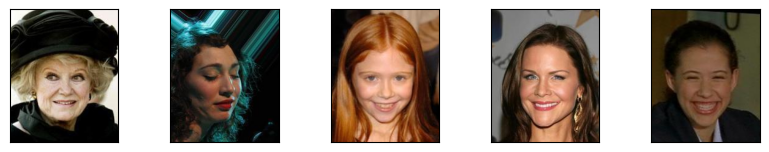

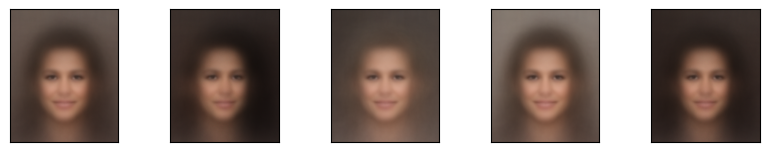

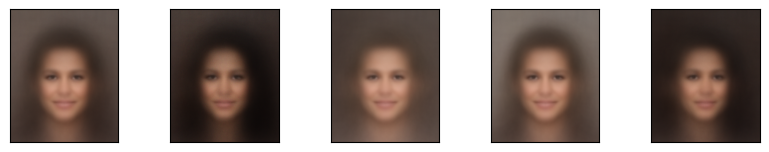

In [ ]:
X, y = next(iter(test_dataloader)) # Obtenir un batch de test
X = X.to(device)
# Prédictions avec les modèles entraînés
# 5 epochs
pred5epochs,_,_ = model5epochs(X,train=False)
pred5epochs = pred5epochs.reshape(X.shape[0], 3, 218, 178)
# 10 epochs
pred10epochs,_,_ = model10epochs(X,train=False)
pred10epochs = pred10epochs.reshape(X.shape[0], 3, 218, 178)

# Affichage des images
def plot_images(images, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(min(5, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy().squeeze())
plot_images(X.cpu())
plot_images(pred5epochs.detach().cpu())
plot_images(pred10epochs.detach().cpu())

Etonnament, le modèle à 5 épochs semble mieux respecter l'orientation du visage. Cependant, le modèle à 10 epochs donne une image plus nette avec des traits moins "génériques", les visages sont plus différents de l'un à l'autre.
Les fond sont très abstraits et unis, seule la teinte change d'une image à l'autre. Les résultats restent peu fidèles à la réalité.

### Espace latent
On visualise l’espace latent appris par le VAE en représentant les codes latents des images du jeu de test, colorés selon la présence ou l’absence d’un attribut particulier.

In [ ]:
def test_encode(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    preds = []
    ys = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            _,pred,_ = model(X,train=False)
            preds.append(pred.detach().cpu().numpy())
            ys += y.numpy().tolist()

    return np.vstack(preds),ys

Ici c'est l'attribut n°1 qui est visualisé. Les points jaunes correspondent aux images qui ont cet attribut. 

(19962, 2)


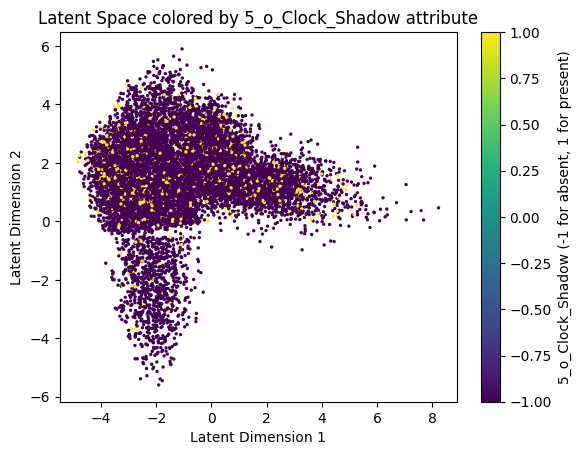

(19962, 2)


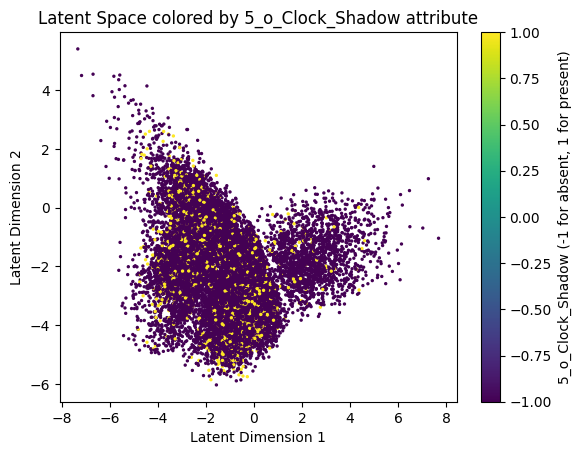

In [ ]:
# Pour le modèle à 5 époques
Z, ys = test_encode(test_dataloader, model5epochs)
print(Z.shape)
ys = np.array(ys)
coloring_attribute = ys[:, 0]

plt.scatter(Z[:,0], Z[:,1], c=coloring_attribute, s=2)

plt.title(f"Latent Space colored by {features[0]} attribute")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")

plt.colorbar(label=f"{features[0]} (-1 for absent, 1 for present)")

plt.show()

# Pour le modèle à 10 époques
Z, ys = test_encode(test_dataloader, model10epochs)
print(Z.shape)
ys = np.array(ys)
coloring_attribute = ys[:, 0]

plt.scatter(Z[:,0], Z[:,1], c=coloring_attribute, s=2)

plt.title(f"Latent Space colored by {features[0]} attribute")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")

plt.colorbar(label=f"{features[0]} (-1 for absent, 1 for present)")

plt.show()

On remarque que les espaces latents de ces deux modèles sont très diférents. En fonction du temps d'entrainement, les points ne sont pas organisés de la même manière.

### Génération aléatoire

On génère et affiche des images aléatoires à partir de codes latents tirés au hasard pour comparer la diversité des visages produits par les modèles entraînés sur 5 et 10 époques. Contrairement aux cellules précédentes où l’on évaluait la reconstruction d’images réelles, ici on explore la capacité du modèle à créer de nouveaux visages.


Generating images from model5epochs:
Generating images from model10epochs:


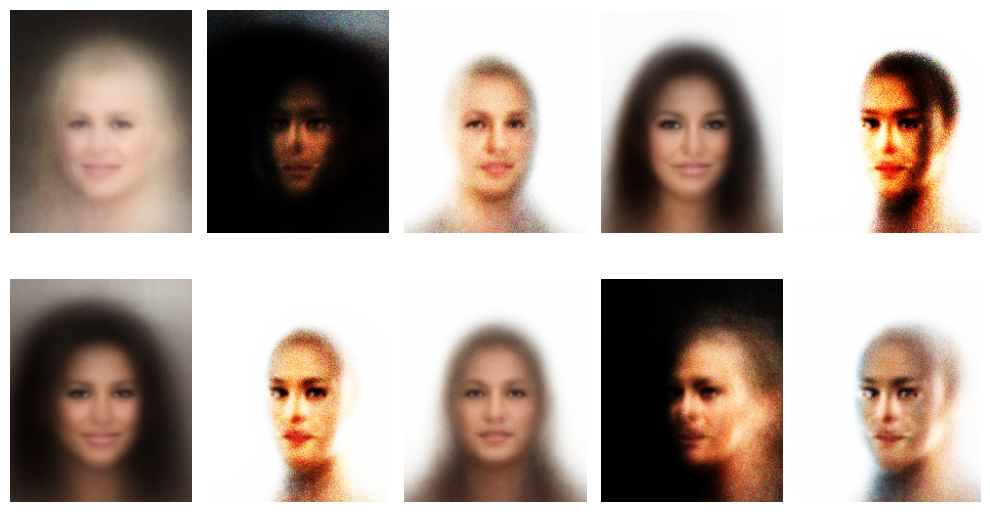

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 6))
axes = axes.flatten()

for i in range(5):
    code = 10 * torch.randn(2).to(device)
    with torch.no_grad():
        y = model5epochs.decoder(code)
    image = y.cpu().detach().numpy().reshape(3, 218, 178)
    axes[i].imshow(np.transpose(image, (1, 2, 0)))
    axes[i].axis("off")

for i in range(5):
    code = 10 * torch.randn(2).to(device)
    with torch.no_grad():
        y = model10epochs.decoder(code)
    image = y.cpu().detach().numpy().reshape(3, 218, 178)
    axes[i+5].imshow(np.transpose(image, (1, 2, 0)))
    axes[i+5].axis("off")


plt.tight_layout()
plt.show()

Avec ce modèle, on remarque que le résultat n'est pas très concluant, qu'importe le nombre d'epochs. On reconnait un visage d'humain mais il manque un grand nombre de détails et les images sont loins de sembler naturelles.

### Amélioration du modèle

On ajoute un couche de neurones au niveau de l'entrée (et donc à la sortie) pour voir s'il est possible d'obtenir des résultats plus probants en captant plus d'informations.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        input_size = 3 * 218 * 178

        self.encoder_mu = nn.Sequential(
            nn.Linear(input_size, 1024), # nouvelle couche
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.encoder_logvar = nn.Sequential(
            nn.Linear(input_size, 1024), # nouvelle couche
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_size), # nouvelle couche
            nn.Sigmoid()
        )


    def forward(self, x, train=True):
        x = self.flatten(x)
        z_mu = self.encoder_mu(x)
        z_logvar = self.encoder_logvar(x)
        std = torch.exp(0.5 * z_logvar)
        if train:
            epsilon = torch.randn_like(std)
            z = z_mu + std * epsilon
        else:
            z = z_mu
        x_hat = self.decoder(z)
        return x_hat, z_mu, z_logvar


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_mu): Sequential(
    (0): Linear(in_features=116412, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
  (encoder_logvar): Sequential(
    (0): Linear(in_features=116412, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_fe

### Entrainement, test et apprentissage


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred,mu,log_sigma = model(X)
        reconstruction_loss = torch.sum((pred.view(X.shape[0], 3, 218, 178) - X).pow(2))
        kl = torch.sum(mu.pow(2) + log_sigma.exp() -1 - log_sigma)
        loss = reconstruction_loss + kl

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0 # Initialize test_loss to 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred,_,_ = model(X,train=False)
            test_loss += torch.nn.functional.mse_loss(pred.view(X.shape[0], 3, 218, 178), X).item()
    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 161439.250000  [   32/162770]
loss: 180894.812500  [ 3232/162770]
loss: 171787.031250  [ 6432/162770]
loss: 168628.796875  [ 9632/162770]
loss: 163378.187500  [12832/162770]
loss: 165576.281250  [16032/162770]
loss: 165700.375000  [19232/162770]
loss: 184385.593750  [22432/162770]
loss: 192923.031250  [25632/162770]
loss: 160190.640625  [28832/162770]
loss: 146860.750000  [32032/162770]
loss: 149961.515625  [35232/162770]
loss: 174534.671875  [38432/162770]
loss: 146634.468750  [41632/162770]
loss: 174391.765625  [44832/162770]
loss: 181761.171875  [48032/162770]
loss: 168364.062500  [51232/162770]
loss: 167763.812500  [54432/162770]
loss: 170405.859375  [57632/162770]
loss: 187380.906250  [60832/162770]
loss: 179307.218750  [64032/162770]
loss: 156454.859375  [67232/162770]
loss: 159107.343750  [70432/162770]
loss: 174606.812500  [73632/162770]
loss: 160887.453125  [76832/162770]
loss: 163433.078125  [80032/162770]
loss: 176543.437500  [83

Voici l'historique des différents tests réalisés et donc des modèles que nous possédons avec cette architecture :
- 56 min pour 5 époques avec un T4.

L'exécution de ce code est beaucoup plus long, et cela est naturel puisque nous avons ajouté une couche avec un nombre de neurones conséquent.

In [ ]:
filename = f"VAE_PART1.2_{epochs}epochs.pth"
torch.save(model.state_dict(), filename)
print("Saved PyTorch Model State")

Saved PyTorch Model State


In [ ]:
model2_5epochs = NeuralNetwork().to(device)
model2_5epochs.load_state_dict(torch.load(f"VAE_PART1.2_5epochs.pth", weights_only=True))

<All keys matched successfully>

On affiche les images originales et leurs reconstructions obtenues avec le modèle amélioré (plus de neurones) entraîné 5 époques, puis on compare visuellement ces résultats avec ceux du modèle précédent entraîné 10 époques.

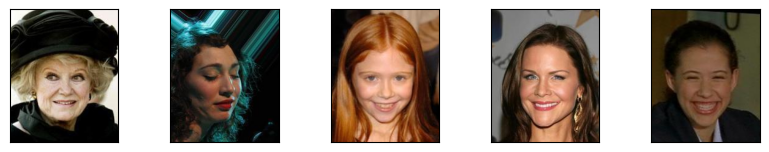

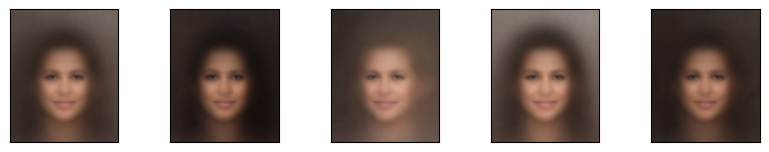

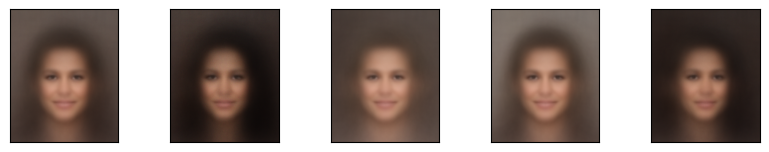

In [ ]:
X, y = next(iter(test_dataloader))
X = X.to(device)
pred5epochs,_,_ = model2_5epochs(X,train=False)
pred5epochs = pred5epochs.reshape(X.shape[0], 3, 218, 178)

def plot_images(images, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(min(5, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy().squeeze())
plot_images(X.cpu())
plot_images(pred5epochs.detach().cpu())
plot_images(pred10epochs.detach().cpu())

Les résultats sont pratiquement les mêmes. En effet, on admet seulement une légère amélioration sur la prise en compte de la direction de la tête et des détails sur le visage qui sont plus étayés, mais il n'y a pas d'amélioration significative. Le temps d'entrainement supplémentaire que cela implique n'est donc pas très intéressant.

### Génération aléatoire

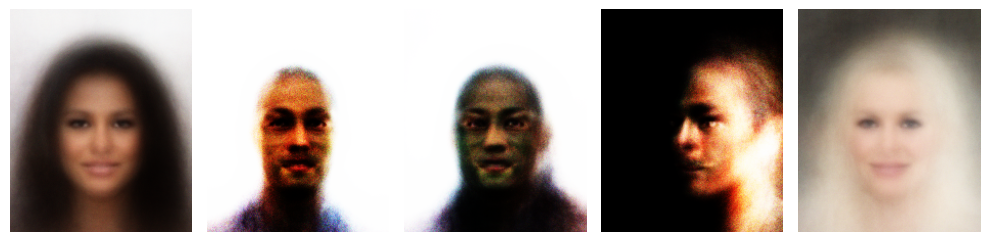

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(10, 6))
axes = axes.flatten()

for i in range(5):
    code = 10 * torch.randn(2).to(device)
    with torch.no_grad():
        y = model2_5epochs.decoder(code)
    image = y.cpu().detach().numpy().reshape(3, 218, 178)
    axes[i].imshow(np.transpose(image, (1, 2, 0)))
    axes[i].axis("off")


plt.tight_layout()
plt.show()

Pour la génération aléatoire on remarque cependant une légère amélioration. Les visages sont mieux détourés et les détails plus présents. Il reste de gros problèmes d'incohérence et de manque de réalisme.

------------------------------------------------------------------------


# Partie 2 : Utiliser des CNN à la place de MLP

On va maintenant créer un CNN en suivant la méthodologie conseillée par le sujet pour comparer les résultats.

### Création du réseau

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        in_channels = 3
        hidden_dims = [32, 64, 128, 256, 512] # Dimensions cachées pour l'encodeur
        self.hidden_dims = hidden_dims.copy()  # On garde une copie pour l'utiliser après reverse
        modules = []

        for h_dim in hidden_dims: # On utilise les dimensions cachées pour l'encodeur
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)

        self.h, self.w = 7, 6 # Dimensions de sortie après l'encodeur
        self.flatten_dim = 512 * self.h * self.w # Dimension aplatie après l'encodeur

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flatten_dim)

        # Decoder
        decoder_hidden_dims = self.hidden_dims.copy()
        decoder_hidden_dims.reverse()

        modules = []
        for i in range(len(decoder_hidden_dims) - 1): # On utilise les dimensions cachées pour le décodeur
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(decoder_hidden_dims[i],
                                       decoder_hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(decoder_hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        # Dernière couche pour revenir à 3 canaux
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(decoder_hidden_dims[-1],
                                   3,
                                   kernel_size=3,
                                   stride=2,
                                   padding=1,
                                   output_padding=1),
                nn.BatchNorm2d(3),
                nn.LeakyReLU())
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        y = self.encoder(x)
        y = y.view(y.size(0), -1)
        mu = self.fc_mu(y)
        logvar = self.fc_logvar(y)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(h.size(0), -1, self.h, self.w)
        out = self.decoder(h)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        x_hat = x_hat[:, :, :x.size(2), :x.size(3)]  # Ajustement si besoin
        return x_hat, mu, logvar

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4):

### Entrainement, test et apprentissage

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        pred,mu,log_sigma = model(X)
        reconstruction_loss = torch.sum((pred.view(X.shape[0], 3, 218, 178) - X).pow(2))
        kl = torch.sum(mu.pow(2) + log_sigma.exp() -1 - log_sigma)
        loss = reconstruction_loss + kl

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred,_,_ = model(X)
            test_loss += torch.nn.functional.mse_loss(pred.view(X.shape[0], 3, 218, 178), X).item()
    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")

In [75]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 1681989.250000  [   32/162770]
loss: 369028.406250  [ 3232/162770]
loss: 356659.000000  [ 6432/162770]
loss: 324113.406250  [ 9632/162770]
loss: 315366.437500  [12832/162770]
loss: 341456.718750  [16032/162770]
loss: 347796.000000  [19232/162770]
loss: 289459.062500  [22432/162770]
loss: 272170.656250  [25632/162770]
loss: 276619.906250  [28832/162770]
loss: 267215.218750  [32032/162770]
loss: 267404.625000  [35232/162770]
loss: 309530.343750  [38432/162770]
loss: 247000.859375  [41632/162770]
loss: 245912.375000  [44832/162770]
loss: 248488.640625  [48032/162770]
loss: 258367.750000  [51232/162770]
loss: 214188.593750  [54432/162770]
loss: 228641.515625  [57632/162770]
loss: 211643.859375  [60832/162770]
loss: 232264.187500  [64032/162770]
loss: 205312.453125  [67232/162770]
loss: 199477.750000  [70432/162770]
loss: 201405.328125  [73632/162770]
loss: 185394.812500  [76832/162770]
loss: 169564.312500  [80032/162770]
loss: 186008.890625  [8

Voici l'historique des différents tests réalisés et donc des modèles que nous possédons avec cette architecture :
- 52 min pour 10 époques avec un T4.

Maintenant, nous allons regarder les résultats de ce CNN.

In [76]:
filename = f"VAE_PART2_{epochs}epochs.pth"
torch.save(model.state_dict(), filename)
print("Saved PyTorch Model State")

Saved PyTorch Model State


In [116]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(f"VAE_PART2_10epochs.pth", weights_only=True))

<All keys matched successfully>

In [117]:
pred,mu,log_sigma = model(X.to(device))
print(pred.shape ,X.shape)

torch.Size([32, 3, 218, 178]) torch.Size([32, 3, 218, 178])


### Affichage

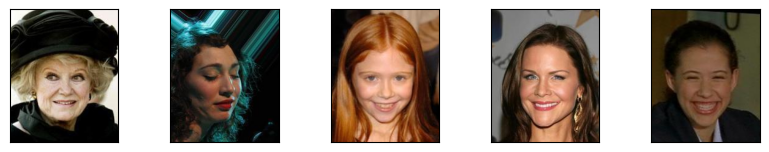

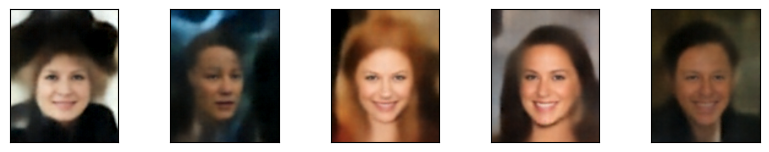

In [81]:
X, y = next(iter(test_dataloader))
X = X.to(device)
y=y.to(device)
pred, _, _ = model(X,y)
pred = pred.reshape(X.shape[0], 3, 218, 178)

def plot_images(images, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(min(5, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_to_show = torch.clamp(images[i].permute(1, 2, 0), 0, 1).cpu().numpy().squeeze()
        plt.imshow(img_to_show)
plot_images(X.cpu())
plot_images(pred.detach().cpu())

Les résultats sont  beaucoup plus satisfaisants avec le CNN, notamment au niveau du fond. Ces derniers sont largement reconnaissables et très fidèles à la réalité, autant au niveau des formes que des couleurs. Les visages, quant à eux, sont modifiés et ne permettent pas toujours de reconnaitre l'originel. Mais les expressions, orientations et couleurs sont respectés. Pour autant, le temps d'apprentissage n'est que légèrement supérieur. Le CNN semble donc plus approprié pour cette tâche.

### Génération aléatoire

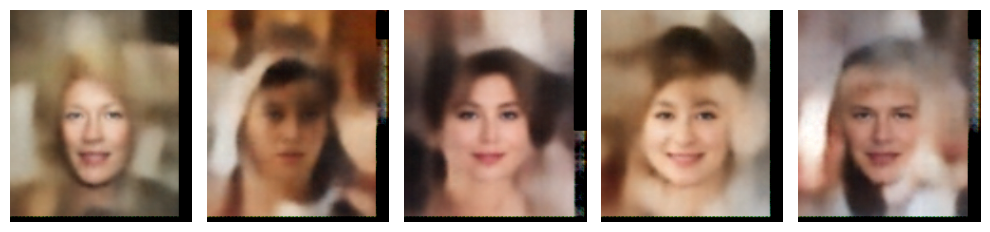

In [ ]:
latent_dim = 128
fig, axes = plt.subplots(1, 5, figsize=(10, 6))
axes = axes.flatten()

model.eval()

for i in range(5):
    z = torch.randn(1, latent_dim).to(device)

    with torch.no_grad():
        y = model.decode(z)

    image = y.cpu().squeeze().numpy()

    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = np.transpose(image, (1, 2, 0))

    if image.ndim == 3 and image.shape[2] == 1:
        image = image.squeeze(axis=2)

    image = np.clip(image, 0, 1)

    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Ici aussi, les résultats sont largement plus satisfaisants avec le CNN. Les visages sont entiers, avec presque tous les éléments qui sont censés le composer, et une expression cohérente. Cependant, les visages ont l'air assemblés avec des éléments inépendants, ce qui réduit le réalisme des scènes. Ce CNN est donc définitivement un outil supérieur au VAE précédent en terme de génération.

------------------------------------------------------------------------

# Partie 3 : Trouver un moyen de conditionner le VAE avec les attributs des images (lunette, moustache etc), l'entrainer et générer votre tête avec des lunettes

On définit un VAE conditionnel basé sur un réseau de neurones convolutifs (CNN) qui prend en compte à la fois l’image et ses attributs (la présence de lunettes, moustache, etc.) pour l’encodage et la génération. On entraîne ce modèle sur le jeu de données afin qu’il puisse générer des visages en fonction des attributs choisis ou les reconstruire de manière plus fidèle en se basant sur ces caractéristiques précises. On évalue ensuite la capacité du modèle à reconstruire ou générer des images en modifiant certains attributs, ce qui permet de visualiser l’influence de ces caractéristiques sur les visages synthétisés.

### Création du modèle

On garde la même structure que le CNN précédent en ajoutant simplement la possibilité d'y préciser un attribut.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        # Encoder
        in_channels = 3
        hidden_dims = [32, 64, 128, 256, 512]
        self.hidden_dims = hidden_dims.copy()  # On garde une copie pour l'utiliser après reverse
        modules = []

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)

        self.h, self.w = 7, 6
        self.flatten_dim = 512 * self.h * self.w

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim + int(features.shape[0]), self.flatten_dim)

        # Decoder
        decoder_hidden_dims = self.hidden_dims.copy()
        decoder_hidden_dims.reverse()

        modules = []
        for i in range(len(decoder_hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(decoder_hidden_dims[i],
                                       decoder_hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(decoder_hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        # Dernière couche pour revenir à 3 canaux
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(decoder_hidden_dims[-1],
                                   3,
                                   kernel_size=3,
                                   stride=2,
                                   padding=1,
                                   output_padding=1),
                nn.BatchNorm2d(3),
                nn.LeakyReLU())
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        y = self.encoder(x)
        y = y.view(y.size(0), -1)
        mu = self.fc_mu(y)
        logvar = self.fc_logvar(y)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, feature): # ajout de feature
        z = torch.cat([z, feature], dim=1)
        h = self.fc_dec(z)
        h = h.view(h.size(0), -1, self.h, self.w)
        out = self.decoder(h)
        return out

    def forward(self, x, feature): # ajout de feature
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, feature) # ajout de feature
        x_hat = x_hat[:, :, :x.size(2), :x.size(3)]
        return x_hat, mu, logvar

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4):

### Entrainement, test et apprentissage

Dans cette partie, on convertit les étiquettes (attributs des images) en tenseurs PyTorch afin de pouvoir les utiliser comme entrées du modèle lors de l’entraînement et du test. On utilise donc `y = y.to(device)` pour transférer les étiquettes sur le même périphérique que les images et le modèle.

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device) # Convertir les étiquettes en tenseurs

        # Compute prediction error
        pred,mu,log_sigma = model(X,y)
        reconstruction_loss = torch.sum((pred.view(X.shape[0], 3, 218, 178) - X).pow(2))
        kl = torch.sum(mu.pow(2) + log_sigma.exp() -1 - log_sigma)
        loss = reconstruction_loss + kl

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0 # Initialize test_loss to 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device) # Convertir les étiquettes en tenseurs
            pred,_,_ = model(X,y)
            test_loss += torch.nn.functional.mse_loss(pred.view(X.shape[0], 3, 218, 178), X).item()
    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")

In [135]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 1867360.500000  [   32/162770]
loss: 416950.281250  [ 3232/162770]
loss: 398600.062500  [ 6432/162770]
loss: 363939.218750  [ 9632/162770]
loss: 352804.093750  [12832/162770]
loss: 378652.218750  [16032/162770]
loss: 390025.625000  [19232/162770]
loss: 310253.718750  [22432/162770]
loss: 289161.562500  [25632/162770]
loss: 284936.968750  [28832/162770]
loss: 262800.250000  [32032/162770]
loss: 258466.062500  [35232/162770]
loss: 288276.218750  [38432/162770]
loss: 233693.859375  [41632/162770]
loss: 232762.140625  [44832/162770]
loss: 224864.500000  [48032/162770]
loss: 234960.843750  [51232/162770]
loss: 191686.500000  [54432/162770]
loss: 209315.593750  [57632/162770]
loss: 188535.531250  [60832/162770]
loss: 195997.625000  [64032/162770]
loss: 172802.437500  [67232/162770]
loss: 155154.000000  [70432/162770]
loss: 149130.109375  [73632/162770]
loss: 125671.484375  [76832/162770]
loss: 113594.054688  [80032/162770]
loss: 126255.539062  [8

In [136]:
filename = f"VAE_PART3_{epochs}epochs.pth"
torch.save(model.state_dict(), filename)
print("Saved PyTorch Model State")

Saved PyTorch Model State


In [ ]:
model = NeuralNetwork().to(device)

model.load_state_dict(torch.load(
    f"VAE_PART3_10epochs.pth",
    map_location=torch.device(device)
))

<All keys matched successfully>

### Affichage

On affiche les images originales du jeu de test ainsi que leurs reconstructions obtenues avec le VAE conditionnel. Ici le modèle utilise à la fois l'image et ses attributs (la présence de lunettes, moustache, etc.) pour générer la reconstruction. Cela permet de visualiser l'impact du conditionnement par les attributs sur la qualité et la fidélité des images reconstruites. On peut ainsi comparer la capacité du modèle à intégrer des informations supplémentaires pour contrôler certains aspects du visage généré.

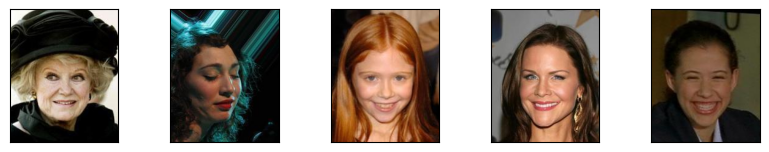

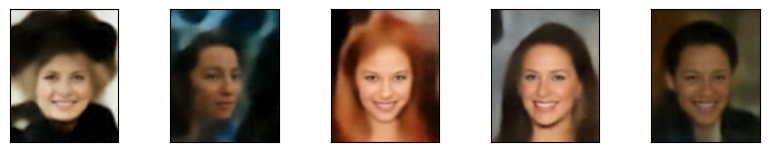

In [ ]:
X, y = next(iter(test_dataloader))
X = X.to(device)
y=y.to(device) # Convertir les étiquettes en tenseurs
pred, _, _ = model(X,y) # ajout de y
pred = pred.reshape(X.shape[0], 3, 218, 178)

def plot_images(images, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(min(5, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_to_show = torch.clamp(images[i].permute(1, 2, 0), 0, 1).cpu().numpy().squeeze()
        plt.imshow(img_to_show)
plot_images(X.cpu())
plot_images(pred.detach().cpu())

Avec le conditionnement par les attributs, les visages générés sont nettement plus ressemblants aux images originales et présentent une grande diversité. Chaque visage synthétisé reflète les caractéristiques spécifiques sélectionnées, ce qui permet d’obtenir des résultats très variés et personnalisés. De nombreux détails sont conservés, ce qui améliore significativement la qualité et la pertinence des images générées par rapport aux modèles non conditionnels.

### Génération aléatoire

Dans cette section, nous allons générer des visages aléatoires à l’aide du VAE conditionnel en utilisant un code latent et en activant aléatoirement trois attributs parmi la liste disponible, ce qui permet d’observer l’influence de différentes combinaisons d’attributs sur les visages synthétisés. On va ensuite regarder si les attributs se retrouvent sur l'image et si cela rend les visages plus réalistes.

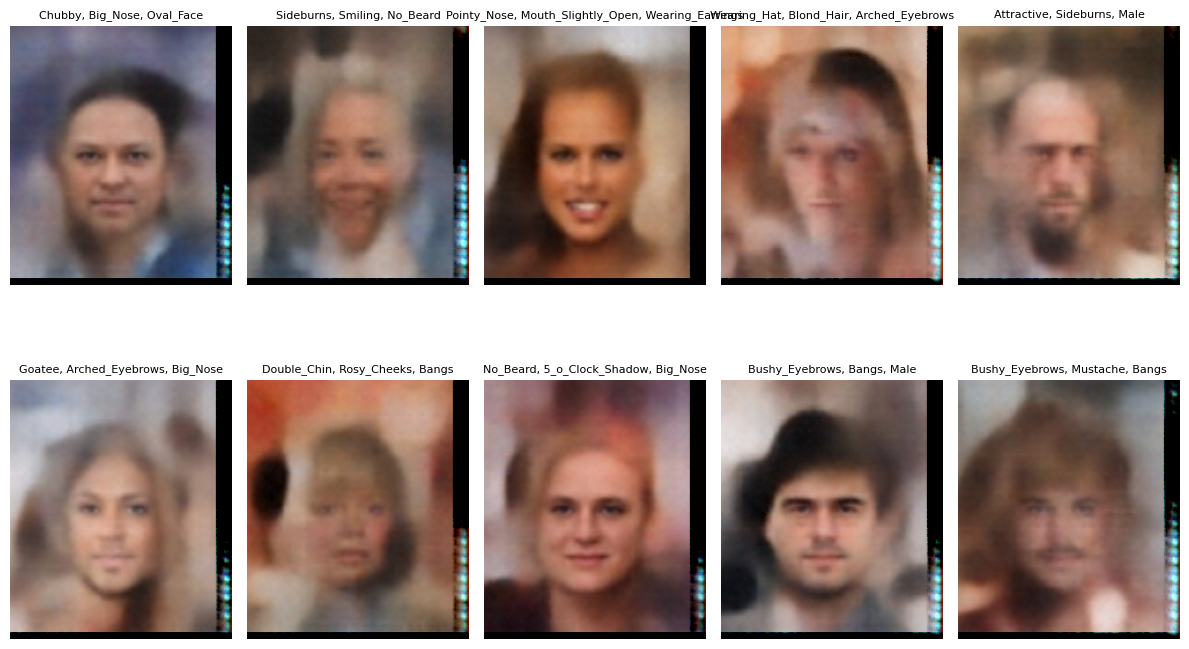

In [ ]:
import random

latent_dim = 128
feature_dim = len(features)

fig, axes = plt.subplots(2, 5, figsize=(12, 8))
axes = axes.flatten()

model.eval()

feature_names = features.tolist()

for i in range(10):
    z = torch.randn(1, latent_dim).to(device)

    if feature_dim >= 3:
        selected_feature_indices = random.sample(range(feature_dim), 3)
    else:
        selected_feature_indices = list(range(feature_dim))


    generated_features = torch.tensor([-1.0] * feature_dim, dtype=torch.float32)
    selected_feature_names = []
    for idx in selected_feature_indices:
        generated_features[idx] = 1.0
        selected_feature_names.append(feature_names[idx])

    generated_features = generated_features.unsqueeze(0).to(device)

    with torch.no_grad():
        y = model.decode(z, generated_features)

    image = y.cpu().squeeze().numpy()

    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = np.transpose(image, (1, 2, 0))

    if image.ndim == 3 and image.shape[2] == 1:
        image = image.squeeze(axis=2)

    image = np.clip(image, 0, 1)

    axes[i].imshow(image, cmap="gray" if image.ndim == 2 else None)
    axes[i].axis("off")

    title = ", ".join(selected_feature_names)
    axes[i].set_title(title, fontsize=8)

plt.tight_layout()
plt.show()

Avec le conditionnement par les attributs, les images générées présentent une légère amélioration en termes de réalisme. On observe que les attributs sélectionnés apparaissent effectivement sur les visages synthétisés, de manière plus ou moins évidente. Cela montre que le modèle a appris à intégrer ces caractéristiques dans la génération, même si le rendu reste parfois imparfait.

### Génération de notre visage avec un attribut

On va ici, à partir d'une photo de nous, essayer d'ajouter des lunettes grâce au modèle qu'on vient d'entrainer. Pour ajouter un attribut sur une photo existante avec ce modèle on va charger la photo et appliquer les transformations (redimensionnement et conversion en tenseur), on définit les attributs présents et on ajoute l'attribut "lunettes", on encode l'image avec le VAE et on le décode avec la condition.
On affiche ensuite l'image résultante.

Attribut ciblé (15) : Eyeglasses
Traitement de : pp1.jpg


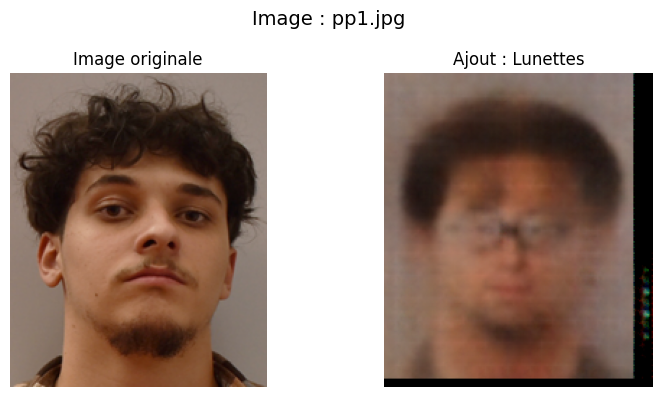

Traitement de : pp2.jpg


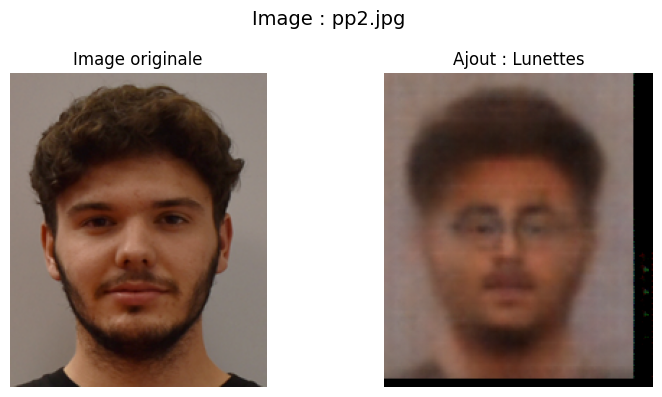

In [ ]:
model.eval()

target_index = 15  # Index correspondant à 'Eyeglasses'
print(f"Attribut ciblé ({target_index}) : {features[target_index]}")

transform = transforms.Compose([
    transforms.Resize((218, 178)),
    transforms.ToTensor()
])

image_files = ['pp1.jpg', 'pp2.jpg']

# -1.0 = attribut désactivé, 1.0 = activé
manual_attributes = [
    [-1.0]*40,  # Attributs pour pp1.jpg
    [-1.0]*40   # Attributs pour pp2.jpg
]

# On personnalise les attributs de chaque image :
manual_attributes[0][11] = 1.0  # Brown Hair
manual_attributes[0][20] = 1.0  # Male
manual_attributes[0][24]  = 1.0  # No Beard
manual_attributes[0][39]  = 1.0  # Young
manual_attributes[0][target_index] = 5.0  # Eyeglasses

manual_attributes[1][11] = 1.0  # Brown Hair
manual_attributes[1][20] = 1.0  # Male
manual_attributes[1][22] = 1.0  # Mustache
manual_attributes[1][39] = 1.0  # Young
manual_attributes[1][target_index] = 5.0  # Eyeglasses

# Transformer les listes en tenseurs
attribute_tensors = [torch.tensor(attr, dtype=torch.float32).to(device) for attr in manual_attributes]

def tensor_to_image(tensor):
    img = tensor.squeeze(0).cpu().numpy()
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    else:
        img = img.squeeze(0)
    return np.clip(img, 0, 1)

for image_file, attributes in zip(image_files, attribute_tensors):
    if not os.path.exists(image_file):
        print(f"Erreur : Le fichier '{image_file}' est introuvable.")
        continue

    print(f"Traitement de : {image_file}")
    image = Image.open(image_file).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        mu, log_var = model.encode(image_tensor)
        latent_code = mu

        attributes = attributes.unsqueeze(0)
        reconstructed = model.decode(latent_code, attributes)

    original_np = tensor_to_image(image_tensor)
    reconstructed_np = tensor_to_image(reconstructed)

    plt.figure(figsize=(8, 4))
    plt.suptitle(f"Image : {image_file}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(original_np)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_np)
    plt.title("Ajout : Lunettes")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Les images générées restent globalement reconnaissables et l’ajout de lunettes est bien visible sur les visages synthétisés. Cependant, on constate que les images sont tout de même fortement modifiées par rapport à l’original, probablement parce que les autres attributs renseignés influencent également les traits du visage. Pour que les lunettes apparaissent clairement, il a été nécessaire d’augmenter fortement la valeur de l’attribut correspondant. Cela montre que le modèle prend bien en compte les attributs, mais qu’il a tendance à modifier l’ensemble du visage pour s’adapter à la combinaison d’attributs fournie.

## Conclusion

Ce projet a permis d’explorer différentes architectures de Variational Autoencoders (VAE) appliquées au jeu de données CelebA, en suivant une progression en trois étapes :

1. **VAE avec MLP (Partie 1)** : Nous avons débuté avec une architecture simple basée sur des couches entièrement connectées (MLP) après avoir aplati les images. La qualité des reconstructions et des générations restait limitée, avec des visages peu détaillés et des fonds abstraits.

2. **VAE avec CNN (Partie 2)** : L’utilisation de réseaux de neurones convolutifs (CNN) a significativement amélioré la qualité des images générées. Les reconstructions sont devenues plus fidèles, notamment au niveau des fonds et des détails du visage, tout en gardant un temps d’entraînement raisonnable. Le CNN s’est révélé bien plus adapté à la nature des images du dataset CelebA.

3. **VAE conditionnel (Partie 3)** : Enfin, en conditionnant le VAE sur les attributs des images (lunettes, moustache, etc.), nous avons pu contrôler certains aspects des visages générés. Le modèle conditionnel a montré sa capacité à intégrer ces attributs dans la génération, permettant de synthétiser des visages avec des caractéristiques précises.

**Bilan général** :  
L’utilisation de CNN et le conditionnement par les attributs permettent d’obtenir des résultats nettement supérieurs à un VAE classique basé sur MLP. Le VAE conditionnel permet de personnaliser des images, et des mieux les reconstruire en suivant des éléments clés présents à l’origine.

Ce travail permet de se rendre compte de l'importance de l'architecture choisie et de la manière dont le conditionnement peut enrichir la capacité de ces modèles à générer des images variées et pertinentes.